# Evaluating properties of testing heterogeneity with / without including local ancestries

1. Different level of heterogeneity (for single causal variant): vary $h_g^2$
2. Different level of simulated heterogeneity (as a ratio of the simulated effects), 0.9, 0.95, 1.0, 1.05, 1.1
3. with / without including local ancestries. 
4. Plot all the metrics

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import pickle
import admix
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import admix_genet_cor
import dask.array as da
import itertools
import os
import submitit

In [2]:
def simulate_test(
    dset: admix.Dataset,
    cov: np.ndarray,
    hsq: float,
    effect_ratio: float,
    n_sim: int = 30,
):
    """
    Perform simulation for each individual variant, and perform 3 tests
    1. without including local ancestry
    2. condition on local ancestry
    3. regress out local ancestry

    Parameters
    ----------
    geno: da.Array
        (n_snp, n_indiv) genotype
    lanc: da.Array
        (n_snp, n_indiv) local ancestry
    cov: np.ndarray
        (n_indiv, n_cov) covariates
    hsq: float
        heritability
    effect_ratio: float
        ratio of the ancestry effect ratio (2nd ancestry) / (1st ancestry)
    n_sim: int
        number of simulations for each variant
        Default to 5.
    """
    geno, lanc = dset.geno, dset.lanc
    dict_rls = {
        "snp": [],
        "hsq": [],
        "effect_ratio": [],
        "sim_i": [],
    }
    for i in range(1, 4):
        for suffix in ["pval", "coef1", "coef2", "se1", "se2"]:
            dict_rls[f"m{i}_{suffix}"] = []

    n_snp, n_indiv = geno.shape[0:2]
    apa = admix.data.allele_per_anc(geno=geno, lanc=lanc, n_anc=2)

    for snp_i in tqdm(range(n_snp)):
        apa_snp = apa[snp_i, :, :]
        lanc_snp = lanc[snp_i, :]

        beta = np.zeros((1, 2, n_sim))
        for i_sim in range(n_sim):
            beta[:, :, i_sim] = np.array([1, effect_ratio]) * np.random.choice([-1, 1])

        sim = admix_genet_cor.simulate_quant_pheno(
            geno=geno[[snp_i], :, :],
            lanc=lanc[[snp_i], :, :],
            hsq=hsq,
            beta=beta,
            n_sim=n_sim,
            verbose=False,
        )

        for sim_i in range(n_sim):
            y_sim = sim["pheno"][:, sim_i]
            # model 1: w/o conditioning
            pval1, model1 = admix_genet_cor.test_snp_het(apa_snp, y_sim, cov)

            # model 2: conditioning on local ancestry
            pval2, model2 = admix_genet_cor.test_snp_het(
                apa_snp, y_sim, np.column_stack([cov, lanc_snp.compute()])
            )

            # model 3: regress out local ancestry
            pval3, model3 = admix_genet_cor.test_snp_het(
                apa_snp, sm.OLS(y_sim, sm.add_constant(lanc_snp)).fit().resid, cov
            )

            # save results
            dict_rls["snp"].append(dset.snp.index[snp_i])
            dict_rls["hsq"].append(hsq)
            dict_rls["effect_ratio"].append(effect_ratio)
            dict_rls["sim_i"].append(sim_i)

            for i, (pval, model) in enumerate(
                [(pval1, model1), (pval2, model2), (pval3, model3)]
            ):
                dict_rls[f"m{i + 1}_pval"].append(pval)
                dict_rls[f"m{i + 1}_coef1"].append(model.params[1])
                dict_rls[f"m{i + 1}_coef2"].append(model.params[2])
                dict_rls[f"m{i + 1}_se1"].append(model.bse[1])
                dict_rls[f"m{i + 1}_se2"].append(model.bse[2])

    df_rls = pd.DataFrame(dict_rls)
    return df_rls


def submit_simulate_test(region_i, hsq, effect_ratio, out):
    """
    Perform simulation
    """
    np.random.seed(admix.utils.str2int(out))
    pfile = f"out/real-dataset/region{region_i}"

    dset = admix.io.read_dataset(pfile=pfile, n_anc=2, snp_chunk=128)

    dset = dset[
        (
            dset.snp.EUR_FREQ.between(0.01, 0.99)
            & dset.snp.AFR_FREQ.between(0.01, 0.99)
        ).values
    ]

    dset = dset[0 : dset.n_snp : (dset.n_snp) // 9]

    dset.persist()

    cov = np.column_stack(
        [dset.indiv[col].values for col in [f"geno_EV{i}" for i in range(1, 3)]]
    )

    df_rls = simulate_test(dset=dset, cov=cov, hsq=hsq, effect_ratio=effect_ratio)
    df_rls.to_csv(out, sep="\t", index=False, float_format="%.6g")

In [3]:
# define the simulation parameters
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            np.arange(100),
            [0.002, 0.006, 0.01],
            [0.9, 0.95, 1.0, 1.05, 1.1],
        )
    ],
    columns=["region", "hsq", "ratio"],
)
df_params["out"] = df_params.apply(
    lambda row: f"out/lanc-pitfall/region-{int(row.region)}-hsq-{row.hsq}-ratio-{row.ratio}.tsv.gz",
    axis=1,
)


df_todo_params = df_params[
    ~df_params.apply(
        lambda x: os.path.exists(x.out),
        axis=1,
    )
]

In [4]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=20,
    memory_g=12,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(
    submit_simulate_test,
    df_todo_params.region,
    df_todo_params.hsq,
    df_todo_params.ratio,
    df_todo_params.out,
)

/u/project/pasaniuc/kangchen/software/submitit-sge/submitit/core/core.py:699: UserWarning: Received an empty job array
  warnings.warn("Received an empty job array")


In [5]:
df_res = []
for f in df_params.out:
    if os.path.exists(f):
        df_tmp = pd.read_csv(f, sep="\t")
        #         df_tmp = df_tmp[df_tmp.snp == df_tmp.snp.unique()[0]]
        df_res.append(df_tmp)
    else:
        print(f"{f} is missing")
df_res = pd.concat(df_res)

# Heterogeity test properties

In [6]:
# heterogeneity
df_het = df_res[
    ["sim_i", "hsq", "effect_ratio"]
    + [col for col in df_res.columns if col.endswith("_pval")]
].copy()

df_het = df_het.groupby(["sim_i", "hsq", "effect_ratio"]).agg(
    {lambda x: np.mean(x < 0.05)}
)
df_het.columns = ["m1", "m2", "m3"]
df_het_mean = df_het.groupby(["hsq", "effect_ratio"]).mean()
df_het_sem = df_het.groupby(["hsq", "effect_ratio"]).sem()


# deming regression
df_deming = []
for method in ["m1", "m2", "m3"]:
    df_tmp = df_res.groupby(["sim_i", "hsq", "effect_ratio"]).apply(
        lambda x: admix_genet_cor.locus.deming_regression(
            x=x[f"{method}_coef1"],
            y=x[f"{method}_coef2"],
            sx=x[f"{method}_se1"],
            sy=x[f"{method}_se2"],
        )[0]
    )
    df_tmp.name = method
    df_deming.append(df_tmp)

df_deming = pd.concat(df_deming, axis=1)
df_deming_mean = df_deming.groupby(["hsq", "effect_ratio"]).mean()
df_deming_sem = df_deming.groupby(["hsq", "effect_ratio"]).sem()

In [7]:
dict_method = {"m1": "w/o", "m2": "lanc conditioned", "m3": "lanc regressed"}

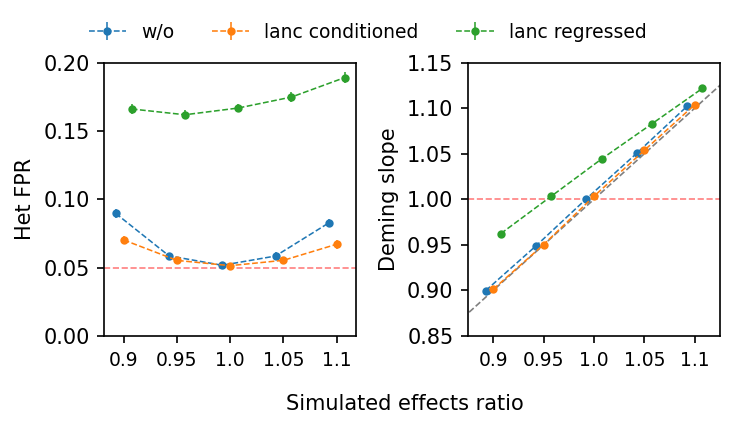

In [15]:
hsq = 0.006

fig, axes = plt.subplots(figsize=(5, 2.4), ncols=2, dpi=150)

# heterogeneity statistics
for method_i in range(3):
    tmp_mean = df_het_mean.loc[hsq, f"m{method_i + 1}"]
    tmp_sem = df_het_sem.loc[hsq, f"m{method_i + 1}"]
    # heterogeneity statistics
    axes[0].errorbar(
        x=np.arange(len(tmp_mean)) + (method_i - 1) * 0.15,
        y=tmp_mean,
        yerr=tmp_sem * 1.96,
        fmt=".--",
        lw=0.75,
        label=dict_method[f"m{method_i + 1}"],
    )

# x-axis
axes[0].set_xticks(np.arange(len(tmp_mean)))
axes[0].set_xticklabels(tmp_mean.index, fontsize=9)

# y-axis
axes[0].set_ylim(0, 0.2)
axes[0].axhline(y=0.05, ls="--", color="red", alpha=0.5, lw=0.8)
axes[0].set_ylabel("Het FPR")

# deming regression
# heterogeneity statistics
for method_i in range(3):
    tmp_mean = df_deming_mean.loc[hsq, f"m{method_i + 1}"]
    tmp_sem = df_deming_sem.loc[hsq, f"m{method_i + 1}"]
    # heterogeneity statistics
    axes[1].errorbar(
        x=np.arange(len(tmp_mean)) + (method_i - 1) * 0.15,
        y=tmp_mean,
        yerr=tmp_sem * 1.96,
        fmt=".--",
        lw=0.75,
        label=f"{method_i}",
    )

# x-axis
axes[1].set_xticks(np.arange(len(tmp_mean)))
axes[1].set_xticklabels(tmp_mean.index, fontsize=9)

# y-axis
axes[1].set_xlim(-0.5, 4.5)
axes[1].set_ylim(0.85, 1.15)
axes[1].axhline(y=1.0, ls="--", color="red", alpha=0.5, lw=0.8)
axes[1].set_ylabel("Deming slope")
axes[1].plot([-1, 5], [0.85, 1.15], color="k", ls="--", lw=0.8, alpha=0.5)


# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.55,
    -0.05,
    "Simulated effects ratio",
    fontsize=10,
    ha="center",
)
fig.tight_layout()
fig.savefig("results/lanc-pitfall.pdf", bbox_inches="tight")

# High correlation of effect count

In [9]:
# x-axis: effect ratio
# legend: m1, m2, m3
# y-axis: heterogeneity / Deming regression

In [10]:
np.random.seed(1234)

df_corr_list = []
for snp_i in tqdm(range(dset.n_snp)):
    apa_snp = apa[snp_i, :, :]
    lanc_snp = lanc[snp_i, :]

    df_corr = pd.DataFrame(
        np.column_stack([apa_snp, lanc_snp]), columns=["EUR", "AFR", "lanc"]
    ).corr()
    df_corr_list.append(df_corr)
    
avg_df_corr = np.zeros_like(df_corr_list[0])
for d in df_corr_list:
    avg_df_corr += d
avg_df_corr /= len(df_corr_list)

NameError: name 'dset' is not defined